In [1]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
import pickle
import sys
from configparser import ConfigParser

#Vconfig_file = sys.argv[1]
#parser = ConfigParser()
#parser.read(Vconfig_file)
import os
import statsmodels.api as sm
from statsmodels.formula.api import ols

#sys.path.insert(0,parser.get('Environment','VenvPath'))
#sys.path.append(parser.get('Environment','SourcePath'))
#proj_folder = os.environ['PricePredictionProj']
proj_folder = 'C:/Users/rsingh/Documents/ADO/PP-PricePrediction'
parser = ConfigParser()
parser.read(proj_folder+'/Deployment/Config/PP_ModelBuilding.ini')


sys.path.insert(0,proj_folder+'/venv/Lib/site-packages/')
sys.path.append(proj_folder+'/Deployment/')


from Library.Utility import *
from Library.Constants import *
from Library.Data_PreProcessing import *

In [2]:
#####Read Price Prediction data File 
datapath = parser.get('Inputdata','DataPath') 
sp_datafile = parser.get('Inputdata','FileName') 


print('Reading Data Files ... ')

raw_dataframe = pd.read_csv(proj_folder + datapath + sp_datafile, 
                 error_bad_lines= False, 
                 encoding = 'unicode_escape')

Reading Data Files ... 


C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (56,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#Total Records and variables from raw data

In [3]:
raw_dataframe.shape

(6810856, 62)

In [4]:
raw_dataframe.head()

,StockID,StockNumber,SalePrice,ECR,ExteriorColorCode,KeysRetainedCodeatSale,SaleDocumentTypeCategory,SaleDocumentTypeDescription,DamageDescriptionPrimary,DamageDescriptionSecondary,...,ProviderID,SellFromStorageLocationID,SellFromLocationName,SellFromAddressLine1,SellFromAddressLine2,SellFromCityName,SellFromStateAbbreviation,SellFromZipCode,ProviderTypeCode,ProviderTypeDescription
0,19198909,18099180,500.0,0.00,WH,1,Salvage,Salvage Certificate,Right Front,Front end,...,7565,4,Honolulu,91-445A Komohana Street,NaN,Kapolei,HI,96707,INS,Insurance company
1,19138118,18044214,3900.0,0.00,SL,1,Salvage,Salvage,Front & Rear,Left Side,...,62168,4,Honolulu,91-445A Komohana Street,NaN,Kapolei,HI,96707,INS,Insurance company
2,19183626,18082707,4000.0,4477.14,GY,1,Clear,Clear,Left Rear,NaN,...,321127,4,Honolulu,91-445A Komohana Street,NaN,Kapolei,HI,96707,SDS,Sale Day Settlement
3,19173236,18078912,900.0,11553.74,SL,1,Bill of Sale,Bill of Sale,Flood,Rear,...,50021,4,Honolulu,91-445A Komohana Street,NaN,Kapolei,HI,96707,INS,Insurance company
4,19147517,18050108,9900.0,3404.00,BL,1,Salvage,Salvage,Right Rear,Theft,...,79,4,Honolulu,91-445A Komohana Street,NaN,Kapolei,HI,96707,INS,Insurance company


In [5]:
raw_dataframe.head(10).to_csv("C:/Users/rsingh/Documents/ADO/EDA_PP/rawdataframe_head.csv")

#Variables List 

In [6]:
len(list(raw_dataframe.columns)), list(raw_dataframe.columns)

(62,
 ['StockID',
  'StockNumber',
  'SalePrice',
  'ECR',
  'ExteriorColorCode',
  'KeysRetainedCodeatSale',
  'SaleDocumentTypeCategory',
  'SaleDocumentTypeDescription',
  'DamageDescriptionPrimary',
  'DamageDescriptionSecondary',
  'DamageTypeCode',
  'DamageSeverityCode',
  'IsRunAndDriveAuction',
  'EngineStatusCode',
  'IsAirbagDeployed',
  'IsAirbagMissing',
  'LossTypeCode',
  'LossTypeDescription',
  'AdministrativeBranchNumber',
  'BranchState',
  'BranchZipCode',
  'ActualCashValue',
  'IsACVOutlier',
  'ModelYear',
  'SoldModelYearAge',
  'OdometerReadingTypeDescription',
  'Mileage',
  'DaysInPhysicalInventory',
  'DaysInPipelineInventory',
  'CountOfRuns',
  'EVMVehicleClass',
  'StockSegment',
  'MakeName',
  'ModelName',
  'BlackbookACV',
  'FuelType',
  'TransmissionType',
  'DriveLineType',
  'IsMissingParts',
  'EngineInformation',
  'EVMCylindersDescription',
  'WatchListCount',
  'AssignmentDateTime',
  'SoldDateTime',
  'IsSoldTimedAuction',
  'SaleMethod',
  'V

#Missing Values Freq Count


In [7]:
miss_pp_rawdataframe  = raw_dataframe.isnull().sum()
miss_pp_rawdataframe 

StockID                         0
StockNumber                     0
SalePrice                       0
ECR                          3488
ExteriorColorCode               0
                             ... 
SellFromCityName             3769
SellFromStateAbbreviation    3769
SellFromZipCode              3769
ProviderTypeCode                0
ProviderTypeDescription         0
Length: 62, dtype: int64

In [8]:
miss_pp_rawdataframe.to_csv("C:/Users/rsingh/Documents/ADO/EDA_PP/miss_pp_rawdataframe.csv")

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


#Data type description of rawdata

In [9]:
raw_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810856 entries, 0 to 6810855
Data columns (total 62 columns):
StockID                           int64
StockNumber                       int64
SalePrice                         float64
ECR                               float64
ExteriorColorCode                 object
KeysRetainedCodeatSale            int64
SaleDocumentTypeCategory          object
SaleDocumentTypeDescription       object
DamageDescriptionPrimary          object
DamageDescriptionSecondary        object
DamageTypeCode                    object
DamageSeverityCode                object
IsRunAndDriveAuction              int64
EngineStatusCode                  object
IsAirbagDeployed                  int64
IsAirbagMissing                   int64
LossTypeCode                      object
LossTypeDescription               object
AdministrativeBranchNumber        int64
BranchState                       object
BranchZipCode                     int64
ActualCashValue                 

In [14]:
# categorical_columns = raw_dataframe.select_dtypes(include = [np.object])

In [16]:
# for i in categorical_columns.columns:
#     print("================== "+i+" ===================")
#     print("----> "+str(raw_dataframe.loc[:,i].nunique())+" Distinct Values in "+i+"\n")
#     print("----> "+str(raw_dataframe.loc[:,i].isna().sum())+" NA Values in "+i+"\n")

#     print(raw_dataframe.loc[:,i].value_counts())
#     print("\n")

================== ExteriorColorCode ===================
----> 27 Distinct Values in ExteriorColorCode

----> 0 NA Values in ExteriorColorCode

BK    1260436
WH    1192579
SL    1048699
GY     921890
BL     619920
RD     539613
GR     233581
GD     199961
MR     122090
TN     110140
BY      79238
BR      78182
BD      70484
LB      65203
BG      50396
        41484
OR      35366
PR      27994
YL      25224
CH      22136
TL      16445
PW      13838
CR      13472
NV       9411
TQ       6378
DB       5584
PK       1112
Name: ExteriorColorCode, dtype: int64


================== SaleDocumentTypeCategory ===================
----> 9 Distinct Values in SaleDocumentTypeCategory

----> 0 NA Values in SaleDocumentTypeCategory

Salvage            4803174
Clear              1490561
Bill of Sale        240365
Parts Only          128442
Non-Repairable      121934
Other                19513
Branded Salvage       5002
Junk                  1859
other                    6
Name: SaleDocumentTypeCategory,

----> 9 Distinct Values in OdometerReadingTypeDescription

----> 0 NA Values in OdometerReadingTypeDescription

Actual                       4016454
Not Required/Exempt          2172908
Not Actual                    467113
Inoperable Digital Dash       116352
Exceeds Mechanical Limits      12537
Burnt                          10758
Unknown                         8553
Broken                          3916
Missing                         2265
Name: OdometerReadingTypeDescription, dtype: int64


================== EVMVehicleClass ===================
----> 69 Distinct Values in EVMVehicleClass

----> 207729 NA Values in EVMVehicleClass

Non Luxury Traditional Compact                                                                                                                                                                              1283683
Non Luxury Traditional Mid Size                                                                                                                    

----> 56 Distinct Values in TransmissionType

----> 326473 NA Values in TransmissionType

Automatic                                     5067534
Manual                                        1258640
ECVT                                           146288
 Automatic                                       3287
4 speed automatic                                1157
Unknown                                          1088
4 speed automatic w/overdrive                    1053
6 Speed automatic                                1024
MANUAL                                            431
ECVT automatic                                    414
Unknown / other automatic                         391
4 speed automatic w/electronic overdrive          387
5 Speed automatic                                 236
Unknown / other                                   232
4 speed automatic w/overdrive                     223
 Manual                                           183
5 speed automatic                             

----> 39 Distinct Values in SellFromAddressLine2

----> 6729786 NA Values in SellFromAddressLine2

605 Healy Road                37809
P.O. Box 192                  21816
Building B                    17444
Kalara St.                     1841
Lot# 23                        1350
Lot H Gate 13                   614
44                              125
Suite B                          19
                                  9
PO Box 353                        5
106                               3
Buffalo County                    3
UNIT F2                           3
8                                 2
Bay 1                             2
968 S Elbert St                   2
Range 11                          1
2000                              1
Hwy 163                           1
P.O. BOX 19040 (71149)            1
124                               1
building 2 unit 6 G               1
Kalispell                         1
# 16743                           1
Houston                           1
B

In [19]:
pp = raw_dataframe.SaleDocumentTypeDescription.value_counts()

In [20]:
pp.to_csv("C:/Users/rsingh/Documents/ADO/EDA_PP/SaleDocumentTypeDescription.csv")

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


#Filter :1. Saleprice should be greater than 25 
         2. Saleprice should not be null
         3. Saleprice <= actual cash value

In [10]:
raw_dataframe.shape

(6810856, 62)

In [11]:
raw_dataframe.SoldDateTime.max()

'2020-01-07 23:46:56.000'

In [12]:
raw_dataframe.SoldDateTime.min()

'2017-01-01 00:15:10.000'

In [13]:
dataframe = raw_dataframe[raw_dataframe['SalePrice'] >= 25]

In [14]:
dataframe.shape

(6802755, 62)

In [15]:
dataframe = dataframe[dataframe['SalePrice'].notnull()]

In [16]:
dataframe.shape

(6802755, 62)

In [17]:
dataframe = dataframe[dataframe['SalePrice'] <= dataframe['ActualCashValue']]

In [18]:
dataframe.shape

(6710975, 62)

#Mileage

In [37]:
#Filter the data based on outliers
# df_No_mileage_outlier = dataframe[(dataframe['Mileage'] > 0 ) & (dataframe['Mileage'] <= 400000)]
# df_with_mileage_outlier = dataframe[~((dataframe['Mileage'] > 0 ) & (dataframe['Mileage'] <= 400000))]


In [38]:
# df_No_mileage_outlier.shape

(6227301, 62)

In [39]:
# df_with_mileage_outlier.shape

(483674, 62)

In [19]:
len(raw_dataframe[raw_dataframe['ScrapValue']>0])

0

#Droping columns will useful for prediction of saleprice

In [20]:
dataframe.drop(['StockStatus', 'BuyerID', 'ProviderID',
       'SellFromStorageLocationID', 'SellFromLocationName',
       'SellFromAddressLine1', 'SellFromAddressLine2', 'SellFromCityName',
       'SellFromStateAbbreviation', 'SellFromZipCode','DamageTypeCode',
        'DamageSeverityCode','ScrapValue','UsedCarValue'],axis = 1,inplace = True)

In [21]:
# categorical_columns = dataframe.select_dtypes(include = [np.object])
continuous_columns = dataframe.select_dtypes(include = [np.int64, np.float64])

In [23]:
continuous_columns.columns #23 columns

Index(['StockID', 'StockNumber', 'SalePrice', 'ECR', 'KeysRetainedCodeatSale',
       'IsRunAndDriveAuction', 'IsAirbagDeployed', 'IsAirbagMissing',
       'AdministrativeBranchNumber', 'BranchZipCode', 'ActualCashValue',
       'IsACVOutlier', 'ModelYear', 'SoldModelYearAge', 'Mileage',
       'DaysInPhysicalInventory', 'DaysInPipelineInventory', 'CountOfRuns',
       'BlackbookACV', 'IsMissingParts', 'WatchListCount',
       'IsSoldTimedAuction', 'VehicleConditionGrade'],
      dtype='object')

In [24]:
selected_cols = ['SalePrice', 'ActualCashValue', 'ModelYear', 'SoldModelYearAge', 'Mileage',
       'DaysInPhysicalInventory', 'DaysInPipelineInventory', 'CountOfRuns','WatchListCount']


In [25]:
my_df = continuous_columns[selected_cols]

In [26]:
my_df.isnull().sum()

SalePrice                        0
ActualCashValue                  0
ModelYear                        0
SoldModelYearAge                 0
Mileage                          0
DaysInPhysicalInventory         16
DaysInPipelineInventory         16
CountOfRuns                 223698
WatchListCount             1608943
dtype: int64

In [27]:
my_df.mean()

SalePrice                    2242.078888
ActualCashValue              9131.718249
ModelYear                    2008.226956
SoldModelYearAge               10.051529
Mileage                    131012.403050
DaysInPhysicalInventory        60.195137
DaysInPipelineInventory        65.217048
CountOfRuns                     1.230405
WatchListCount                 17.375398
dtype: float64

In [28]:
my_df.median()

SalePrice                    1100.0
ActualCashValue              6699.0
ModelYear                    2008.0
SoldModelYearAge               10.0
Mileage                    107495.0
DaysInPhysicalInventory        42.0
DaysInPipelineInventory        47.0
CountOfRuns                     1.0
WatchListCount                 10.0
dtype: float64

In [29]:
my_df.mode()

,SalePrice,ActualCashValue,ModelYear,SoldModelYearAge,Mileage,DaysInPhysicalInventory,DaysInPipelineInventory,CountOfRuns,WatchListCount
0,200.0,500.0,2007,11,0,20.0,27.0,1.0,1.0


In [69]:
# for i in continuous_columns.columns:
#     print("================== "+i+" ===================")
#     print("----> "+str(raw_dataframe.loc[:,i].nunique())+" Distinct Values in "+i+"\n")
#     print("----> "+str(raw_dataframe.loc[:,i].isna().sum())+" NA Values in "+i+"\n")

#     print(raw_dataframe.loc[:,i].value_counts())
#     print("\n")

================== ExteriorColorCode ===================
----> 27 Distinct Values in ExteriorColorCode

----> 0 NA Values in ExteriorColorCode

BK    1260436
WH    1192579
SL    1048699
GY     921890
BL     619920
RD     539613
GR     233581
GD     199961
MR     122090
TN     110140
BY      79238
BR      78182
BD      70484
LB      65203
BG      50396
        41484
OR      35366
PR      27994
YL      25224
CH      22136
TL      16445
PW      13838
CR      13472
NV       9411
TQ       6378
DB       5584
PK       1112
Name: ExteriorColorCode, dtype: int64


================== SaleDocumentTypeCategory ===================
----> 9 Distinct Values in SaleDocumentTypeCategory

----> 0 NA Values in SaleDocumentTypeCategory

Salvage            4803174
Clear              1490561
Bill of Sale        240365
Parts Only          128442
Non-Repairable      121934
Other                19513
Branded Salvage       5002
Junk                  1859
other                    6
Name: SaleDocumentTypeCategory,

----> 69 Distinct Values in EVMVehicleClass

----> 207729 NA Values in EVMVehicleClass

Non Luxury Traditional Compact                                                                                                                                                                              1283683
Non Luxury Traditional Mid Size                                                                                                                                                                             1262807
Non Luxury Compact CUV                                                                                                                                                                                       650355
Non Luxury Traditional Full Size                                                                                                                                                                             385737
Non Luxury Full Size Half Ton Pickup                            

----> 56 Distinct Values in TransmissionType

----> 326473 NA Values in TransmissionType

Automatic                                     5067534
Manual                                        1258640
ECVT                                           146288
 Automatic                                       3287
4 speed automatic                                1157
Unknown                                          1088
4 speed automatic w/overdrive                    1053
6 Speed automatic                                1024
MANUAL                                            431
ECVT automatic                                    414
Unknown / other automatic                         391
4 speed automatic w/electronic overdrive          387
5 Speed automatic                                 236
Unknown / other                                   232
4 speed automatic w/overdrive                     223
 Manual                                           183
5 speed automatic                             

In [ ]:
ax = (my_df['SalePrice']).plot.hist(bins=30, alpha=0.5)

In [30]:
import matplotlib.pyplot as plt
plt.show()

In [41]:
#99%ile point for SalePrice
my_df['SalePrice'].quantile(0.99)

16000.0

In [35]:
my_df['SalePrice'].quantile(0.25), my_df['SalePrice'].quantile(0.50), my_df['SalePrice'].quantile(0.75)

(400.0, 1100.0, 2700.0)

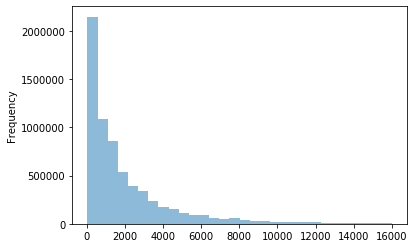

In [31]:
#99%ile point for SalePrice
ax = my_df[my_df['SalePrice'] < my_df['SalePrice'].quantile(0.99)]['SalePrice'].plot.hist(bins=30, alpha=0.5)

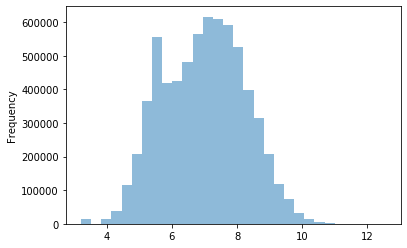

In [36]:
# my_df = my_df[my_df['SalePrice'] < 10000]
ax = np.log(my_df['SalePrice']).plot.hist(bins=30, alpha=0.5)

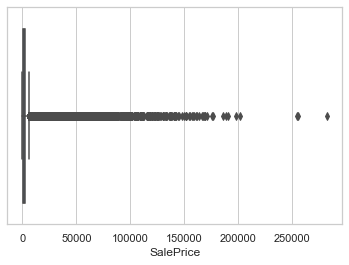

In [37]:
import seaborn as sns
sns.set(style="whitegrid")
# tips = sns.load_dataset("tips")
ax = sns.boxplot(x=my_df["SalePrice"])

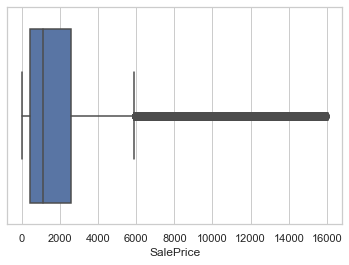

In [38]:
ax = sns.boxplot(x=my_df[my_df["SalePrice"]< 16000]['SalePrice'])

In [43]:
# my_df['ActualCashValue'].quantile(0.99)
my_df.columns

Index(['SalePrice', 'ActualCashValue', 'ModelYear', 'SoldModelYearAge',
       'Mileage', 'DaysInPhysicalInventory', 'DaysInPipelineInventory',
       'CountOfRuns', 'WatchListCount'],
      dtype='object')

In [47]:
for col in my_df.columns:
    print(col)
    print(my_df[col].quantile(0.25), my_df[col].quantile(0.50), my_df[col].quantile(0.75), my_df[col].quantile(0.99))

SalePrice
400.0 1100.0 2700.0 16000.0
ActualCashValue
3600.0 6699.0 11945.0 40000.0
ModelYear
2004.0 2008.0 2013.0 2018.0
SoldModelYearAge
5.0 10.0 14.0 26.0
Mileage
50036.0 107495.0 160178.0 999999.0
DaysInPhysicalInventory
25.0 42.0 70.0 338.0
DaysInPipelineInventory
28.0 47.0 76.0 352.0
CountOfRuns
1.0 1.0 1.0 4.0
WatchListCount
4.0 10.0 22.0 109.0


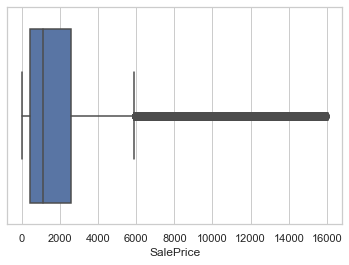

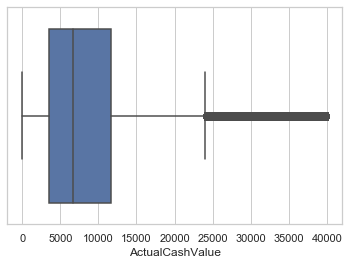

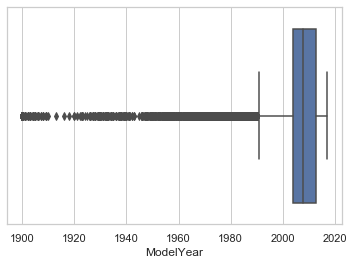

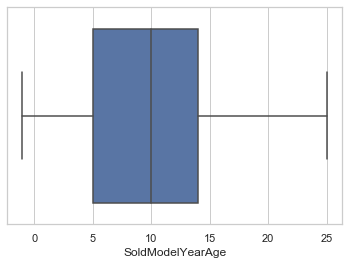

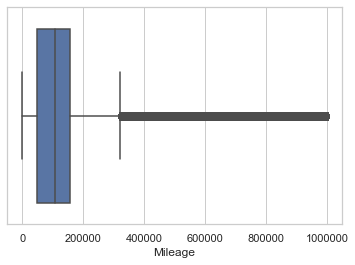

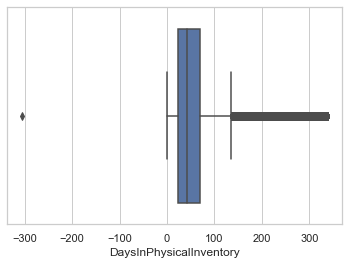

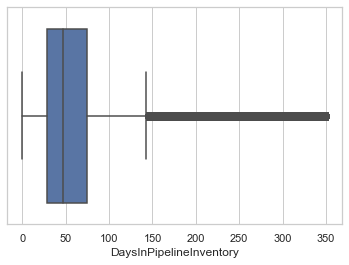

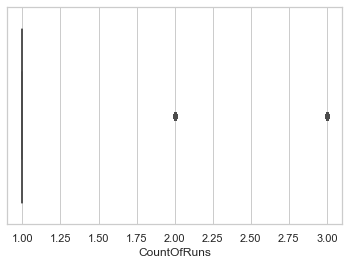

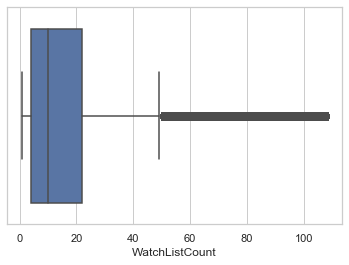

In [44]:
for col in my_df.columns:
    ax = sns.boxplot(x=my_df[my_df[col]< my_df[col].quantile(0.99)][col])
    plt.show()

In [70]:
from numpy import nansum
from numpy import nanmean
from numpy import nanstd


In [71]:
loc_SaleDocumentTypeDescription = dataframe.groupby(['SaleDocumentTypeDescription'],as_index=False).agg({'SalePrice':[nanmean],'ActualCashValue':[nanmean],'StockID':'count'}).reset_index()

In [72]:
loc_SaleDocumentTypeDescription

,index,SaleDocumentTypeDescription,SalePrice,ActualCashValue,StockID
,,,nanmean,nanmean,count
0,0,ACQ BOS,1725.914991,7997.621499,1094
1,1,ACQ BOS - Dismantler Only,812.500000,2287.500000,4
2,2,Abandon-Cert,850.000000,5355.000000,1
3,3,Abandon-Cert-Endorsement,673.983051,4282.050847,59
4,4,Abandoned,407.817982,5410.099157,664
...,...,...,...,...,...
151,151,US Govt Certificate,100.000000,1587.000000,1
152,152,Unrecovered Theft,2285.000000,6825.875000,10
153,153,Vessel Certificate,4701.666667,18969.946400,75


In [50]:
loc_SaleDocumentTypeDescription.to_csv("C:/Users/rsingh/Documents/ADO/EDA_PP/loc_SaleDocumentTypeDescription.csv")

#LossTypeDescription : Descriptive Statistics 

In [51]:
loc_LossTypeDescription = dataframe.groupby(['LossTypeDescription'],as_index=False).agg({'SalePrice':[nanmean],'ActualCashValue':[nanmean],'StockID':'count'}).reset_index()

In [52]:
loc_LossTypeDescription

,index,LossTypeDescription,SalePrice,ActualCashValue,StockID
,,,nanmean,nanmean,count
0,0,Collision,2294.082265,9830.696054,5062177
1,1,Fire,1253.364499,13084.829595,70188
2,2,Other,1789.419826,5258.314803,1277044
3,3,Theft,2971.829404,11031.032164,113814
4,4,Water,3846.084720,14002.653130,187752


In [73]:
loc_LossTypeDescription_med = dataframe.groupby(['LossTypeDescription'],as_index=False).agg({'SalePrice':'median','ActualCashValue':'median','StockID':'count'})

In [74]:
loc_LossTypeDescription_med

,LossTypeDescription,SalePrice,ActualCashValue,StockID
0,Collision,1300.0,7463.01,5062177
1,Fire,275.0,8215.00,70188
2,Other,650.0,2550.00,1277044
3,Theft,1300.0,8375.00,113814
4,Water,2200.0,10753.00,187752


#Colorcode

In [59]:
ExteriorColorCode_mean = dataframe.groupby(['ExteriorColorCode'],as_index=False).agg({'SalePrice':[nanmean],'ActualCashValue':[nanmean],'StockID':'count'}).reset_index()

In [60]:
ExteriorColorCode_mean

,index,ExteriorColorCode,SalePrice,ActualCashValue,StockID
,,,nanmean,nanmean,count
0,0,,4902.215099,22571.344068,36705
1,1,BD,2059.626681,8615.978754,69732
2,2,BG,1340.619810,6101.651060,49344
3,3,BK,2665.930062,10608.711841,1245456
4,4,BL,1881.061631,8118.929248,611782
5,5,BR,2432.282773,9982.474240,76812
6,6,BY,1809.255261,7828.424279,78118
7,7,CH,1321.589800,5990.706358,21746
8,8,CR,1722.267553,7898.516003,13175


In [61]:
ExteriorColorCode_med = dataframe.groupby(['ExteriorColorCode'],as_index=False).agg({'SalePrice':'median','ActualCashValue':'median','StockID':'count'})

In [62]:
ExteriorColorCode_med

,ExteriorColorCode,SalePrice,ActualCashValue,StockID
0,,2500.0,15000.000,36705
1,BD,1000.0,6338.000,69732
2,BG,600.0,4107.000,49344
3,BK,1450.0,8196.000,1245456
4,BL,1000.0,5939.000,611782
5,BR,1300.0,7652.000,76812
6,BY,850.0,5566.000,78118
7,CH,600.0,4230.880,21746
8,CR,900.0,5895.000,13175
9,DB,1500.0,8479.805,5522


In [75]:
StockTypeDescription_mean = dataframe.groupby(['StockTypeDescription'],as_index=False).agg({'SalePrice':[nanmean],'ActualCashValue':[nanmean],'StockID':'count'}).reset_index()

In [76]:
StockTypeDescription_mean

,index,StockTypeDescription,SalePrice,ActualCashValue,StockID
,,,nanmean,nanmean,count
0,0,ATV,2078.930435,7522.675043,115
1,1,Automobile,2196.490244,8927.633672,6511670
2,2,Boat,5361.619902,18941.602508,6813
3,3,Bus,3211.616315,28693.241273,1186
4,4,Crane,19879.000000,190602.490000,25
5,5,Emergency Equipment,3605.679803,62059.446502,203
6,6,Farm Equipment,5727.087866,36857.082446,1537
7,7,Forestry Equipment,3581.707317,49733.585122,41
8,8,Heavy Equipment,11277.673298,42927.099158,1307


#StockSegment_mean

In [85]:
StockSegment_mean = dataframe.groupby(['StockSegment'],as_index=False).agg({'SalePrice':[nanmean],'ActualCashValue':[nanmean],'StockID':'count'}).reset_index()

In [86]:
StockSegment_mean

,index,StockSegment,SalePrice,ActualCashValue,StockID
,,,nanmean,nanmean,count
0,0,Domestic Sedan,1419.308815,7229.576385,1272028
1,1,Foreign Sedan,1982.927674,8327.928640,2692524
2,2,Motorcycle,2264.297316,8095.796642,86179
3,3,Other,3804.018483,16474.616749,59241
4,4,Pickup,3424.456443,12208.782854,618017
5,5,Pickup,9141.000000,27285.402400,25
6,6,Pickup Truck,6915.986699,35561.388302,19832
7,7,SUV,2847.845752,10624.089176,1612412
8,8,Van,1813.161000,7436.540872,350717
